In [107]:
import glob
import random
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from tqdm import tqdm
import numpy as np

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in simple_preprocess(text, min_len = 4):
        if token not in STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

cat_list = glob.glob ("categories/*")
cat_size = len(cat_list)

random.seed(0)
cat_names = []
cat_text = []
sample_size = min(30, cat_size)
cat_sample = sorted(random.sample(range(cat_size), sample_size))

count = 0
for i in cat_sample:
    cat_names.append(cat_list[i].replace("\\", "/").split('/')[-1][:-4].replace("_"," "))
    with open(cat_list[i]) as f:
        cat_text.append(f.read().replace("\n", "").replace("\r",""))

processed_docs = [preprocess(text) for text in tqdm(cat_text)]
dictionary = corpora.Dictionary(processed_docs)
print("Before prunn:%d"%(len(dictionary)))
dictionary.filter_extremes(no_above=0.5)
print("After prunn:%d"%(len(dictionary)))
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:52<00:00,  8.20s/it]

Before prunn:90213
After prunn:10484


In [108]:
import math

def cosine_similarity(a, b):
    b = dict(b)
    norm_a = 0
    norm_b = 0
    denom = 0
    for a_i, a_v in a:
        norm_a += a_v * a_v
        if a_i in b:
            denom += a_v * b[a_i]
    for b_i in b:
        norm_b += b[b_i] * b[b_i]
    
    norm_a = math.sqrt(norm_a)
    norm_b = math.sqrt(norm_b)
#     print(norm_a)
#     print(norm_b)
#     print(denom)
    
    return denom / (norm_a * norm_b)

In [112]:
import numpy as np
import pandas as pd

sim = np.zeros([len(corpus), len(corpus)])

for i in tqdm(range(0, len(corpus) - 1)):
    for j in range(i + 1, len(corpus)):
        sim[i][j] = cosine_similarity(corpus[i], corpus[j])

sim_df = pd.DataFrame(sim)
sim_df.index = cat_names
sim_df.columns = cat_names


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 48.49it/s]

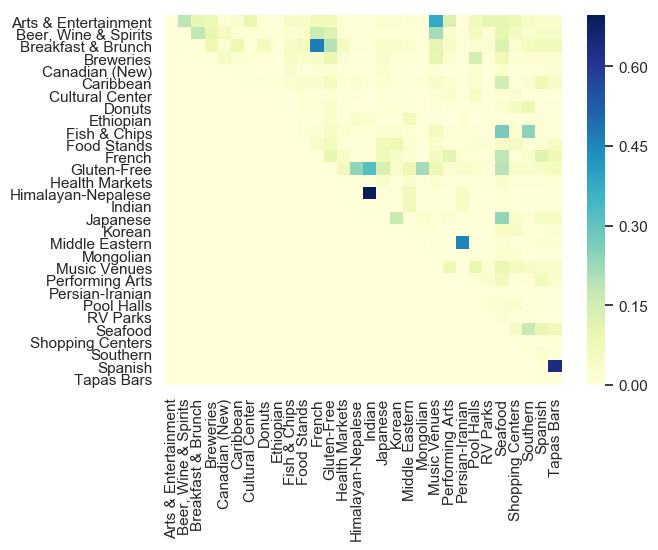

In [113]:

import seaborn as sns; 
import matplotlib.pyplot as plt

# data = pd.read_csv("cuisine_sim_matrix.csv", header=None)
# data.index = cat_names
# data.columns = cat_names
ax = sns.heatmap(sim_df,cmap="YlGnBu", xticklabels=True, yticklabels=True)
plt.show()